# Trabajo Final de Aprendizaje de Máquina

### Walmart Recruiting: Trip Type Classification


**J. Adrián Sánchez Castro**   116369<br>
**Nohemí Limnones Calvillo**    136135<br>
**Manuel Ríos Zagal**           159284<br>


#### Diciembre, 2016

Instituto Tecnológico Autónomo de México

## Introducción

El proyecto final consiste en clasificar tipos de viajes de compras basándose en los artículos que compraron los clientes. Para dar algunos ejemplos hipotéticos de tipos de viaje: un cliente puede hacer un pequeño viaje diario para la cena, un viaje semanal para compra de muchos comestibles, un viaje para comprar regalos para unas próximas vacaciones, o un viaje temporada para comprar ropa.

Walmart ha categorizado los viajes contenidos en estos datos en 38 distintos tipos usando un método patentado aplicado a un conjunto extendido de datos. Se le reta a recrear esta categorización / agrupación con un conjunto más limitado de características.


Para resolver el proyecto se utilizarán 3 algoritmos de aprendizaje máquina: Regresión Logística, Bosques Aleatorios y K-Vecinos Cercanos. El objetivo es tratar de lograr el mayor porcentaje de certeza en la predicción del tipo de viaje.

Este proyecto es entregado en un *Ipython Jupyter Notebook* que se encuentra dividido en cuatro secciones.

- **Sección 1.** Análisis Exploratorio de Datos
- **Sección 2.** Limpieza y Transformación de Datos<br>
- **Sección 3.** Modelado
- **Sección 4.** Análisis de Resultados

## Sección 1. Análisis Exploratorio de Datos

In [50]:
#importamos todas las librerias
import pandas as pd
import numpy as np
import re 
import matplotlib.pyplot as plt
import scipy

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.pipeline import Pipeline



plt.style.use('ggplot')
%matplotlib inline

In [2]:
data = pd.read_csv("data/train.csv")
data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [3]:
data.count()

TripType                 647054
VisitNumber              647054
Weekday                  647054
Upc                      642925
ScanCount                647054
DepartmentDescription    645693
FinelineNumber           642925
dtype: int64

In [4]:
print(647054-642925)
print(4129/647054)

4129
0.006381229387346342


Podemos ver que hay 4129 filas que se encuentran vacías y representan al rededor .6 % y podemos remover 

In [5]:
len(data.TripType.unique())

38

## Sección 2. Limpieza y Transformación de Datos

In [6]:
#Primero vamos a importar la base de train y la base de test
#Vamos a imprimir un head de 5 observaciones de cada uno para ver como luce la tabla

#Base de train
train = pd.read_csv("data/train.csv")
train.head(5)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [7]:
#Base de test
test = pd.read_csv("data/test.csv")
test.head(5)

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,1,Friday,7.250339e+10,1,SHOES,3002.0
1,1,Friday,1.707711e+09,1,DAIRY,1526.0
2,1,Friday,8.947000e+10,1,DAIRY,1431.0
3,1,Friday,8.849121e+10,1,GROCERY DRY GOODS,3555.0
4,2,Friday,2.840015e+09,1,DSD GROCERY,4408.0


### Funciones

Vamos a definir dos funciones que no permitiran hacer "wrangling" y "engineering" a los datasets.
Estas funciones realizan lo siguiente:
(Falta explicar las funciones)

Las dos funciones existen tanto para train, como para test.

In [8]:
def feature_engineering_train(data):
    "Funcion para hacer engineering al dataset"
    #Cambiando nombres a las columnas
    data.columns = ["tipo_viaje", "ticket", "dia", "codigo_barras", "items_comprados",
           "departamento","categoria_walmart"]
    #Creando columna de devolucion
    data.loc[data.items_comprados < 0, 'devolucion'] = 1
    data.loc[data.devolucion != 1, 'devolucion'] = 0
    
    #Creando dummies de departamento
    data = pd.get_dummies(data, columns = ["departamento"])
    
    #Creando dummies de los dias
    dias = ["Monday","Tuesday","Wednesday","Thursday", "Friday", "Saturday", "Sunday"]
    data.dia = data.dia.astype("category", ordered=True, categories = dias).cat.codes
    
    #Agregando suma de los items al dataframe
    data_dummies = data.iloc[:,7:]
    data_dummies = data_dummies.apply(lambda x: x*data["items_comprados"])
    data_dummies = data_dummies.replace(-0,0)
    
    #Juntando base
    data = data[["tipo_viaje", "ticket", "dia", "items_comprados", "devolucion"]]
    data = pd.concat([data, data_dummies], axis=1)
    
    #Creando dummies tipo de viajes
    data.tipo_viaje = data.tipo_viaje.astype("category").cat.codes
    
    #Agrupando base
    aggregation = {'tipo_viaje':np.max,'dia': np.max, 'items_comprados': np.sum, 'devolucion': np.max,
                   'departamento_1-HR PHOTO': np.sum,
       'departamento_ACCESSORIES': np.sum, 'departamento_AUTOMOTIVE': np.sum,
       'departamento_BAKERY': np.sum, 'departamento_BATH AND SHOWER': np.sum,
       'departamento_BEAUTY': np.sum, 'departamento_BEDDING': np.sum,
       'departamento_BOOKS AND MAGAZINES': np.sum, 'departamento_BOYS WEAR': np.sum,
       'departamento_BRAS & SHAPEWEAR': np.sum, 'departamento_CAMERAS AND SUPPLIES': np.sum,
       'departamento_CANDY, TOBACCO, COOKIES': np.sum, 'departamento_CELEBRATION': np.sum,
       'departamento_COMM BREAD': np.sum, 'departamento_CONCEPT STORES': np.sum,
       'departamento_COOK AND DINE': np.sum, 'departamento_DAIRY': np.sum,
       'departamento_DSD GROCERY': np.sum, 'departamento_ELECTRONICS': np.sum,
       'departamento_FABRICS AND CRAFTS': np.sum, 'departamento_FINANCIAL SERVICES': np.sum,
       'departamento_FROZEN FOODS': np.sum, 'departamento_FURNITURE': np.sum,
       'departamento_GIRLS WEAR, 4-6X  AND 7-14': np.sum,
       'departamento_GROCERY DRY GOODS': np.sum, 'departamento_HARDWARE': np.sum,'departamento_HOME DECOR': np.sum,
       'departamento_HOME MANAGEMENT': np.sum, 'departamento_HORTICULTURE AND ACCESS': np.sum,
       'departamento_HOUSEHOLD CHEMICALS/SUPP': np.sum,
       'departamento_HOUSEHOLD PAPER GOODS': np.sum,
       'departamento_IMPULSE MERCHANDISE': np.sum, 'departamento_INFANT APPAREL': np.sum,
       'departamento_INFANT CONSUMABLE HARDLINES': np.sum,
       'departamento_JEWELRY AND SUNGLASSES': np.sum, 'departamento_LADIES SOCKS': np.sum,
       'departamento_LADIESWEAR': np.sum, 'departamento_LARGE HOUSEHOLD GOODS': np.sum,
       'departamento_LAWN AND GARDEN': np.sum, 'departamento_LIQUOR,WINE,BEER': np.sum,
       'departamento_MEAT - FRESH & FROZEN': np.sum, 'departamento_MEDIA AND GAMING': np.sum,
       'departamento_MENS WEAR': np.sum, 'departamento_MENSWEAR': np.sum,
       'departamento_OFFICE SUPPLIES': np.sum, 'departamento_OPTICAL - FRAMES': np.sum,
       'departamento_OPTICAL - LENSES': np.sum, 'departamento_OTHER DEPARTMENTS': np.sum,
       'departamento_PAINT AND ACCESSORIES': np.sum, 'departamento_PERSONAL CARE': np.sum,
       'departamento_PETS AND SUPPLIES': np.sum, 'departamento_PHARMACY OTC': np.sum,
       'departamento_PHARMACY RX': np.sum, 'departamento_PLAYERS AND ELECTRONICS': np.sum,
       'departamento_PLUS AND MATERNITY': np.sum, 'departamento_PRE PACKED DELI': np.sum,
       'departamento_PRODUCE': np.sum, 'departamento_SEAFOOD': np.sum, 'departamento_SEASONAL': np.sum,
       'departamento_SERVICE DELI': np.sum, 'departamento_SHEER HOSIERY': np.sum,
       'departamento_SHOES': np.sum, 'departamento_SLEEPWEAR/FOUNDATIONS': np.sum,
       'departamento_SPORTING GOODS': np.sum, 'departamento_SWIMWEAR/OUTERWEAR': np.sum,
       'departamento_TOYS': np.sum, 'departamento_WIRELESS': np.sum}
    
    grouped = data.groupby("ticket")
    grouped = grouped.agg(aggregation)
    
    data = grouped[['tipo_viaje','dia','items_comprados','devolucion','departamento_DSD GROCERY', 'departamento_FURNITURE',
       'departamento_1-HR PHOTO','departamento_HOUSEHOLD PAPER GOODS', 'departamento_OPTICAL - FRAMES',
       'departamento_BOOKS AND MAGAZINES',
       'departamento_CANDY, TOBACCO, COOKIES', 
       'departamento_LADIESWEAR', 'departamento_OFFICE SUPPLIES',
       'departamento_BEAUTY', 'departamento_PLUS AND MATERNITY',
       'departamento_PRE PACKED DELI', 'departamento_BAKERY',
       'departamento_PHARMACY RX', 'departamento_MENS WEAR',
       'departamento_TOYS', 'departamento_GROCERY DRY GOODS',
       'departamento_LADIES SOCKS', 'departamento_PRODUCE',
       'departamento_SWIMWEAR/OUTERWEAR',
       'departamento_PLAYERS AND ELECTRONICS',
       'departamento_MEAT - FRESH & FROZEN', 'departamento_PETS AND SUPPLIES',
       'departamento_CELEBRATION', 'departamento_INFANT APPAREL',
       'departamento_HOUSEHOLD CHEMICALS/SUPP', 'departamento_LAWN AND GARDEN',
       'departamento_DAIRY', 'departamento_ACCESSORIES',
       'departamento_BATH AND SHOWER',
       'departamento_INFANT CONSUMABLE HARDLINES',
       'departamento_LIQUOR,WINE,BEER', 'departamento_LARGE HOUSEHOLD GOODS',
       'departamento_MEDIA AND GAMING', 'departamento_AUTOMOTIVE',
       'departamento_PERSONAL CARE', 'departamento_HOME DECOR',
       'departamento_CAMERAS AND SUPPLIES', 'departamento_SERVICE DELI',
       'departamento_OPTICAL - LENSES', 'departamento_HARDWARE',
       'departamento_GIRLS WEAR, 4-6X  AND 7-14',
       'departamento_HOME MANAGEMENT', 'departamento_BEDDING',
       'departamento_MENSWEAR', 'departamento_BOYS WEAR',
       'departamento_PHARMACY OTC', 'departamento_SEASONAL',
       'departamento_JEWELRY AND SUNGLASSES',
       'departamento_FINANCIAL SERVICES', 'departamento_SHEER HOSIERY',
       'departamento_COMM BREAD', 'departamento_SEAFOOD',
       'departamento_BRAS & SHAPEWEAR', 'departamento_SLEEPWEAR/FOUNDATIONS',
       'departamento_SPORTING GOODS', 'departamento_COOK AND DINE',
       'departamento_CONCEPT STORES', 'departamento_FABRICS AND CRAFTS',
       'departamento_HORTICULTURE AND ACCESS',
       'departamento_OTHER DEPARTMENTS', 'departamento_ELECTRONICS',
       'departamento_PAINT AND ACCESSORIES', 'departamento_FROZEN FOODS',
       'departamento_WIRELESS', 'departamento_SHOES',
       'departamento_IMPULSE MERCHANDISE']]
    
    return data

In [9]:
def feature_engineering_test(data):
    "Funcion para hacer engineering al dataset"
    #Cambiando nombres a las columnas
    data.columns = ["ticket", "dia", "codigo_barras", "items_comprados",
           "departamento","categoria_walmart"]
    #Creando columna de devolucion
    data.loc[data.items_comprados < 0, 'devolucion'] = 1
    data.loc[data.devolucion != 1, 'devolucion'] = 0
    
    #Creando dummies de departamento
    data = pd.get_dummies(data, columns = ["departamento"])
    
    #Creando dummies de los dias
    dias = ["Monday","Tuesday","Wednesday","Thursday", "Friday", "Saturday", "Sunday"]
    data.dia = data.dia.astype("category", ordered=True, categories = dias).cat.codes
    
    #Agregando suma de los items al dataframe
    data_dummies = data.iloc[:,6:]
    data_dummies = data_dummies.apply(lambda x: x*data["items_comprados"])
    data_dummies = data_dummies.replace(-0,0)
    
    #Juntando base
    data = data[["ticket","dia", "items_comprados", "devolucion"]]
    data = pd.concat([data, data_dummies], axis=1)

    
    #Agrupando base
    aggregation = {'dia': np.max, 'items_comprados': np.sum, 'devolucion': np.max,
                   'departamento_1-HR PHOTO': np.sum,
       'departamento_ACCESSORIES': np.sum, 'departamento_AUTOMOTIVE': np.sum,
       'departamento_BAKERY': np.sum, 'departamento_BATH AND SHOWER': np.sum,
       'departamento_BEAUTY': np.sum, 'departamento_BEDDING': np.sum,
       'departamento_BOOKS AND MAGAZINES': np.sum, 'departamento_BOYS WEAR': np.sum,
       'departamento_BRAS & SHAPEWEAR': np.sum, 'departamento_CAMERAS AND SUPPLIES': np.sum,
       'departamento_CANDY, TOBACCO, COOKIES': np.sum, 'departamento_CELEBRATION': np.sum,
       'departamento_COMM BREAD': np.sum, 'departamento_CONCEPT STORES': np.sum,
       'departamento_COOK AND DINE': np.sum, 'departamento_DAIRY': np.sum,
       'departamento_DSD GROCERY': np.sum, 'departamento_ELECTRONICS': np.sum,
       'departamento_FABRICS AND CRAFTS': np.sum, 'departamento_FINANCIAL SERVICES': np.sum,
       'departamento_FROZEN FOODS': np.sum, 'departamento_FURNITURE': np.sum,
       'departamento_GIRLS WEAR, 4-6X  AND 7-14': np.sum,
       'departamento_GROCERY DRY GOODS': np.sum, 'departamento_HARDWARE': np.sum,'departamento_HOME DECOR': np.sum,
       'departamento_HOME MANAGEMENT': np.sum, 'departamento_HORTICULTURE AND ACCESS': np.sum,
       'departamento_HOUSEHOLD CHEMICALS/SUPP': np.sum,
       'departamento_HOUSEHOLD PAPER GOODS': np.sum,
       'departamento_IMPULSE MERCHANDISE': np.sum, 'departamento_INFANT APPAREL': np.sum,
       'departamento_INFANT CONSUMABLE HARDLINES': np.sum,
       'departamento_JEWELRY AND SUNGLASSES': np.sum, 'departamento_LADIES SOCKS': np.sum,
       'departamento_LADIESWEAR': np.sum, 'departamento_LARGE HOUSEHOLD GOODS': np.sum,
       'departamento_LAWN AND GARDEN': np.sum, 'departamento_LIQUOR,WINE,BEER': np.sum,
       'departamento_MEAT - FRESH & FROZEN': np.sum, 'departamento_MEDIA AND GAMING': np.sum,
       'departamento_MENS WEAR': np.sum, 'departamento_MENSWEAR': np.sum,
       'departamento_OFFICE SUPPLIES': np.sum, 'departamento_OPTICAL - FRAMES': np.sum,
       'departamento_OPTICAL - LENSES': np.sum, 'departamento_OTHER DEPARTMENTS': np.sum,
       'departamento_PAINT AND ACCESSORIES': np.sum, 'departamento_PERSONAL CARE': np.sum,
       'departamento_PETS AND SUPPLIES': np.sum, 'departamento_PHARMACY OTC': np.sum,
       'departamento_PHARMACY RX': np.sum, 'departamento_PLAYERS AND ELECTRONICS': np.sum,
       'departamento_PLUS AND MATERNITY': np.sum, 'departamento_PRE PACKED DELI': np.sum,
       'departamento_PRODUCE': np.sum, 'departamento_SEAFOOD': np.sum, 'departamento_SEASONAL': np.sum,
       'departamento_SERVICE DELI': np.sum, 'departamento_SHEER HOSIERY': np.sum,
       'departamento_SHOES': np.sum, 'departamento_SLEEPWEAR/FOUNDATIONS': np.sum,
       'departamento_SPORTING GOODS': np.sum, 'departamento_SWIMWEAR/OUTERWEAR': np.sum,
       'departamento_TOYS': np.sum, 'departamento_WIRELESS': np.sum}
    
    grouped = data.groupby("ticket")
    grouped = grouped.agg(aggregation)
    
    data = grouped[['dia','items_comprados','devolucion','departamento_DSD GROCERY', 'departamento_FURNITURE',
       'departamento_1-HR PHOTO','departamento_HOUSEHOLD PAPER GOODS', 'departamento_OPTICAL - FRAMES',
       'departamento_BOOKS AND MAGAZINES',
       'departamento_CANDY, TOBACCO, COOKIES', 
       'departamento_LADIESWEAR', 'departamento_OFFICE SUPPLIES',
       'departamento_BEAUTY', 'departamento_PLUS AND MATERNITY',
       'departamento_PRE PACKED DELI', 'departamento_BAKERY',
       'departamento_PHARMACY RX', 'departamento_MENS WEAR',
       'departamento_TOYS', 'departamento_GROCERY DRY GOODS',
       'departamento_LADIES SOCKS', 'departamento_PRODUCE',
       'departamento_SWIMWEAR/OUTERWEAR',
       'departamento_PLAYERS AND ELECTRONICS',
       'departamento_MEAT - FRESH & FROZEN', 'departamento_PETS AND SUPPLIES',
       'departamento_CELEBRATION', 'departamento_INFANT APPAREL',
       'departamento_HOUSEHOLD CHEMICALS/SUPP', 'departamento_LAWN AND GARDEN',
       'departamento_DAIRY', 'departamento_ACCESSORIES',
       'departamento_BATH AND SHOWER',
       'departamento_INFANT CONSUMABLE HARDLINES',
       'departamento_LIQUOR,WINE,BEER', 'departamento_LARGE HOUSEHOLD GOODS',
       'departamento_MEDIA AND GAMING', 'departamento_AUTOMOTIVE',
       'departamento_PERSONAL CARE', 'departamento_HOME DECOR',
       'departamento_CAMERAS AND SUPPLIES', 'departamento_SERVICE DELI',
       'departamento_OPTICAL - LENSES', 'departamento_HARDWARE',
       'departamento_GIRLS WEAR, 4-6X  AND 7-14',
       'departamento_HOME MANAGEMENT', 'departamento_BEDDING',
       'departamento_MENSWEAR', 'departamento_BOYS WEAR',
       'departamento_PHARMACY OTC', 'departamento_SEASONAL',
       'departamento_JEWELRY AND SUNGLASSES',
       'departamento_FINANCIAL SERVICES', 'departamento_SHEER HOSIERY',
       'departamento_COMM BREAD', 'departamento_SEAFOOD',
       'departamento_BRAS & SHAPEWEAR', 'departamento_SLEEPWEAR/FOUNDATIONS',
       'departamento_SPORTING GOODS', 'departamento_COOK AND DINE',
       'departamento_CONCEPT STORES', 'departamento_FABRICS AND CRAFTS',
       'departamento_HORTICULTURE AND ACCESS',
       'departamento_OTHER DEPARTMENTS', 'departamento_ELECTRONICS',
       'departamento_PAINT AND ACCESSORIES', 'departamento_FROZEN FOODS',
       'departamento_WIRELESS', 'departamento_SHOES',
       'departamento_IMPULSE MERCHANDISE']]
    
    return data

Funcion para contar el numero de categorias que involucra cada ticket.
Esta funcion existe tanto para train como para test.

In [10]:
# para cada fila a partir de la columna 4, suma uno por cada tipo de producto comprado en una lista y lo apendea en una lista
def category_count_train(data):
    alist = []
    for array in np.asarray(data.iloc[:,4:]):
        count = 0
        for item in array:
            if item > 0:
                count += 1
        alist.append(count)
    cat_counts = pd.DataFrame(alist)
    cat_counts = cat_counts.rename(columns={0:"total_tipo_productos"})
    cat_counts = cat_counts.set_index(data.index)
    data.insert(4, 'total_categorias_compradas', cat_counts)
    
    return data

In [11]:
# para cada fila a partir de la columna 4, suma uno por cada tipo de producto comprado en una lista y lo apendea en una lista
def category_count_test(data):
    alist = []
    for array in np.asarray(data.iloc[:,3:]):
        count = 0
        for item in array:
            if item > 0:
                count += 1
        alist.append(count)
    cat_counts = pd.DataFrame(alist)
    cat_counts = cat_counts.rename(columns={0:"total_tipo_productos"})
    cat_counts = cat_counts.set_index(data.index)
    data.insert(3, 'total_categorias_compradas', cat_counts)
    
    return data

In [12]:
#Aplicamos las dos funciones al train
train = feature_engineering_train(train)
train = category_count_train(train)

In [13]:
#Aplicamos las dos funciones al test
test = feature_engineering_test(test)
test = category_count_test(test)

In [14]:
#Si imprimimos el shape de cada base, vemos que el test tiene una columna menos
#Esta columna menos es la variable a predecir train
print(train.shape)
print(test.shape)

(95674, 72)
(95674, 71)


De esta manera ya tenemos listas nuestras dos bases. Tanto nuestra base de <b>train</b>, donde modelaremos, hasta nuestra
base de <b>test</b>, donde haremos prediccion y generaremos un "submission" para la plataforma de Kaggle.

### 3. Modelado

#### Vamos a crear las bases de train y test antes del modelado

In [15]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

In [46]:
#Separamos la base de datos original de train en train y test nuevamente 
train_2,test_2 = train_test_split(train, test_size=0.3)

In [48]:
#Vamos a separar las variables explicativas(x`s) y la variable a predecir(y) en las dos bases

#Base de train
y_train = train_2["tipo_viaje"]
x_train = train_2.drop("tipo_viaje", axis=1).values.astype(float)

#Base de test
y_test = test_2["tipo_viaje"]
x_test = test_2.drop("tipo_viaje", axis=1).values.astype(float)

### Regresión Logística

In [49]:
#Vamos a plicar regresion logistica y predecimos en cross-validation
#A este modelo lo llamaremos modelo_1
LR = LogisticRegression()
LR.fit(X = np.asarray(x_train), y = np.asarray(y_train))

pred_prob = LR.predict_proba(np.asarray(x_test))
pred_noprob = LR.predict(np.asarray(x_test))

print("Porcentaje de Pérdida Logarítmica: {}".format(log_loss(y_test, pred_prob).round(5)))
print("Resultado de Precisión del Modelo: {}".format(accuracy_score(y_test, pred_noprob)))

Porcentaje de Pérdida Logarítmica: 1.28253
Resultado de Precisión del Modelo: 0.6402118245479567


Podemos ver que nuestro modelo tiene una precicision de ~<b>65%</b> en el cross-validation.

### KNN

Para el modelado del KNN vamos a realizar PCA.

###### PCA & KNN

In [53]:
#Vamos a crear PCA antes del KNN
pca = PCA(n_components=7, whiten=True)
pca.fit(x_train)

PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

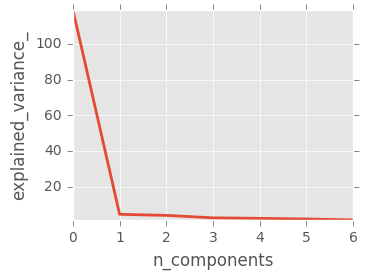

In [54]:
#Imprimimos el PCA y la varianza acorde al numero de componentes
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [61]:
#Hacemos KNN con los 7 componentes principales
KNN = KNeighborsClassifier(n_neighbors=3, weights="distance")
KNN.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance')

In [62]:
pred_noprob = KNN.predict(x_test)
print("Resultado de Precisión del Modelo: {}".format(accuracy_score(y_test, pred_noprob)))

Resultado de Precisión del Modelo: 0.6115040239696199


Vemos que el modelo de KNN tiene una precision de ~<b>61%</b> en el cross-validation.

(Falta solo un modelo)

## Bosques Aleatorios

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
bosque = RandomForestClassifier(n_estimators = 300, max_features=2)

In [38]:
bosque = bosque.fit(np.asarray(train_2[param]), np.asarray(train_2.tipo_visita))

In [ ]:
#predicciones = bosque.predict_proba(np.asarray(test_2[param]))
#predicciones_noProba = bosque.predict(np.asarray(test_2[fe]))
print("Porcentaje de Pérdida Logarítmica: {}".format(log_loss(test_2.tipo_visita, predicciones).round(5)))
print("Resultado de Precisión del Modelo: {}".format(sklearn.metrics.accuracy_score(test_2.tipo_visita, predicciones_noProba)))

# Clasificador de Soporte Vectorial

In [46]:
from sklearn.svm import LinearSVC
LSVC= LinearSVC()
LSVC = LSVC.fit(np.asarray(train_2[param]), np.asarray(train_2.tipo_visita))

#### Predeciendo en el test original. Creando "submission" para Kaggle.